# Metrics Calculation

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report

df = pd.read_csv("../Classification/NER_with_ensemble_sentiment.csv")
df.head()

,id,subreddit,author,score,created_utc,type,num_comments,permalink,title,selftext,...,unique_word_count,ner_text_cleaned,ner_recognized_tickers,ner_entity_sentiments,qwen_sentiments,human1_sentiment,human2_sentiment,ensemble_results,primary_sentiment,primary_score
0,1iy04ol,applestocks,No-Drive8630,2,1740503556,post,3.0,https://www.reddit.com/r/applestocks/comments/...,Buy apple today! ????,Stock is up compared to the market. Board vot...,...,26,Buy AAPL today Stock is up compared to the mar...,AAPL,"{""AAPL"": {""finbert"": {""label"": ""Slightly Posit...",{'AAPL': {'qwen': {'label': 'Positive'}}},{'AAPL': {'human1': {'label': 'Slightly Positi...,"{""AAPL"": {""human2"": {""label"": ""Slightly Positi...","{'AAPL': {'sentiment': 'slightly positive', 's...",slightly positive,0.410751
1,1ixdqih,applestocks,DekeJeffery,2,1740432978,post,1.0,https://www.reddit.com/r/applestocks/comments/...,Apple will spend more than $500 billion in the...,NaN,...,15,AAPL will spend more than 500 billion in the U...,AAPL,"{""AAPL"": {""finbert"": {""label"": ""Neutral"", ""net...",{'AAPL': {'qwen': {'label': 'Positive'}}},{'AAPL': {'human1': {'label': 'Neutral'}}},"{""AAPL"": {""human2"": {""label"": ""Neutral""}}}","{'AAPL': {'sentiment': 'neutral', 'score': 0.0...",neutral,0.000000
2,1iunfst,applestocks,DekeJeffery,3,1740131997,post,1.0,https://www.reddit.com/r/applestocks/comments/...,"AAPL iPhone 16e Built for A.I., Weighing Headw...",NaN,...,10,AAPL AAPL 16e Built for A I Weighing Headwinds...,AAPL,"{""AAPL"": {""finbert"": {""label"": ""Neutral"", ""net...",{'AAPL': {'qwen': {'label': 'Neutral'}}},{'AAPL': {'human1': {'label': 'Neutral'}}},"{""AAPL"": {""human2"": {""label"": ""Neutral""}}}","{'AAPL': {'sentiment': 'neutral', 'score': 0.0...",neutral,0.000000
3,1iu3lir,applestocks,thesatisfiedplethora,0,1740071513,post,2.0,https://www.reddit.com/r/applestocks/comments/...,FAQ For Getting Payment On Apple $490M Investo...,"Hey guys, I posted about this settlement recen...",...,142,FAQ For Getting Payment On AAPL 490M Investor ...,AAPL,"{""AAPL"": {""finbert"": {""label"": ""Neutral"", ""net...",{'AAPL': {'qwen': {'label': 'Neutral'}}},{'AAPL': {'human1': {'label': 'Neutral'}}},"{""AAPL"": {""human2"": {""label"": ""Neutral""}}}","{'AAPL': {'sentiment': 'neutral', 'score': 0.0...",neutral,0.000000
4,1ifidhu,applestocks,goldenson,1,1738449363,post,0.0,https://www.reddit.com/r/applestocks/comments/...,Below is a structured extraction of key highli...,**Below is a structured extraction of key high...,...,393,Below is a structured extraction of key highli...,AAPL,"{""AAPL"": {""finbert"": {""label"": ""Slightly Posit...",{'AAPL': {'qwen': {'label': 'Positive'}}},{'AAPL': {'human1': {'label': 'Slightly Positi...,"{""AAPL"": {""human2"": {""label"": ""Slightly Positi...","{'AAPL': {'sentiment': 'slightly positive', 's...",slightly positive,0.642683


## Inter-Annotator Agreement

Total paired labels found: 1221
Cohen's kappa: 0.8028
Percent agreement: 88.29%


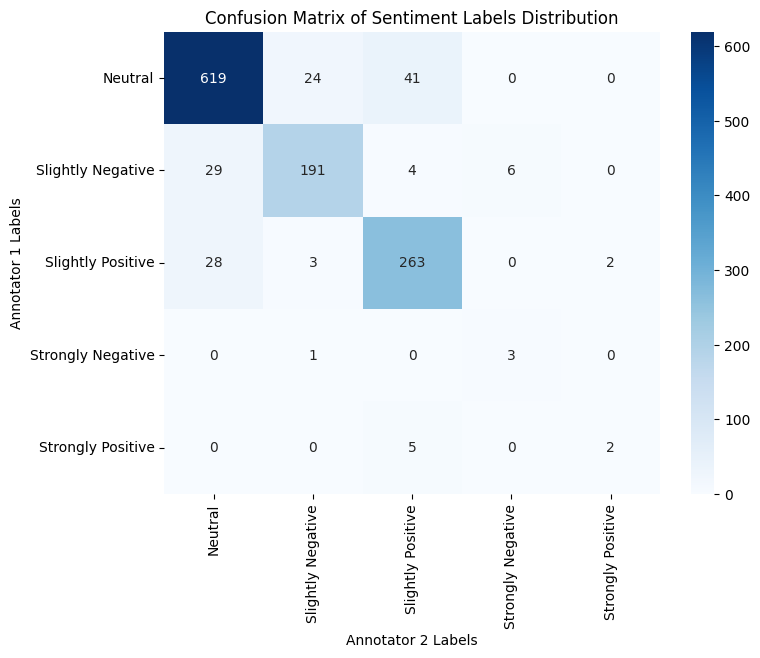

In [ ]:
def safe_json_parse(x):
    if isinstance(x, str):
        try:
            return json.loads(x.replace("'", '"'))
        except:
            return {}
    return x if isinstance(x, dict) else {}

h1_labels = []
h2_labels = []

for idx, row in df.iterrows():
    h1 = safe_json_parse(row['human1_sentiment'])
    h2 = safe_json_parse(row['human2_sentiment'])
    
    companies = set(h1.keys()).intersection(h2.keys())
    for company in companies:
        def get_first_label(data):
            for annotator in data.get(company, {}):
                levels = data[company][annotator]
                if isinstance(levels, dict):
                    for value in levels.values():
                        return value
            return None
        
        h1_label = get_first_label(h1)
        h2_label = get_first_label(h2)
        
        if h1_label is not None and h2_label is not None:
            h1_labels.append(h1_label)
            h2_labels.append(h2_label)

# Calculate Cohen's kappa and percent agreement
if h1_labels and h2_labels:
    kappa = cohen_kappa_score(h1_labels, h2_labels)
    agreement = sum([h1 == h2 for h1, h2 in zip(h1_labels, h2_labels)]) / len(h1_labels)
    
    print(f"Total paired labels found: {len(h1_labels)}")
    print(f"Cohen's kappa: {kappa:.4f}")
    print(f"Percent agreement: {agreement:.2%}")
    
    # Generate confusion matrix
    labels = sorted(list(set(h1_labels) | set(h2_labels)))
    cm = confusion_matrix(h1_labels, h2_labels, labels=labels)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Annotator 2 Labels')
    plt.ylabel('Annotator 1 Labels')
    plt.title('Confusion Matrix of Sentiment Labels Distribution')
    plt.show()
else:
    print("No matching label pairs found for comparison.")


## Evaluation Metrics

In [3]:
def safe_json_parse(x):
    if isinstance(x, str):
        try:
            return json.loads(x.replace("'", '"'))
        except:
            return {}
    return x if isinstance(x, dict) else {}

def evaluate_annotator(df, human_col):
    human_labels = []
    ens_labels = []
    
    for idx, row in df.iterrows():
        human = safe_json_parse(row[human_col])
        ens = safe_json_parse(row['ensemble_results'])
        companies = set(human.keys()).intersection(ens.keys())
        
        for company in companies:
            def get_first_label(data):
                for annotator in data.get(company, {}):
                    levels = data[company][annotator]
                    if isinstance(levels, dict):
                        for value in levels.values():
                            return value
                return None
            
            human_label = get_first_label(human)
            ens_label = ens.get(company, {}).get('sentiment')
            
            if human_label is not None and ens_label is not None:
                human_labels.append(human_label)
                ens_labels.append(ens_label.title() if isinstance(ens_label, str) else ens_label)
    
    if human_labels and ens_labels:
        accuracy = accuracy_score(human_labels, ens_labels)
        precision = precision_score(human_labels, ens_labels, average='weighted', zero_division=0)
        recall = recall_score(human_labels, ens_labels, average='weighted', zero_division=0)
        f1 = f1_score(human_labels, ens_labels, average='weighted', zero_division=0)
        report = classification_report(human_labels, ens_labels, zero_division=0)
        
        # Create confusion matrix
        labels = sorted(list(set(human_labels) | set(ens_labels)))
        cm = confusion_matrix(human_labels, ens_labels, labels=labels)
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'report': report,
            'n': len(human_labels),
            'human_labels': human_labels,
            'ens_labels': ens_labels,
            'confusion_matrix': cm,
            'labels': labels
        }
    return None

### Human 1

Individual Evaluation Results (Human1 vs Ensemble):
Accuracy: 0.7420
Precision: 0.7595
Recall: 0.7420
F1 Score: 0.7471
Total samples: 1221

Classification Report (Human1):
                   precision    recall  f1-score   support

          Neutral       0.81      0.79      0.80       684
Slightly Negative       0.77      0.59      0.67       230
Slightly Positive       0.66      0.77      0.71       296
Strongly Negative       0.09      0.25      0.13         4
Strongly Positive       0.05      0.14      0.07         7

         accuracy                           0.74      1221
        macro avg       0.48      0.51      0.48      1221
     weighted avg       0.76      0.74      0.75      1221



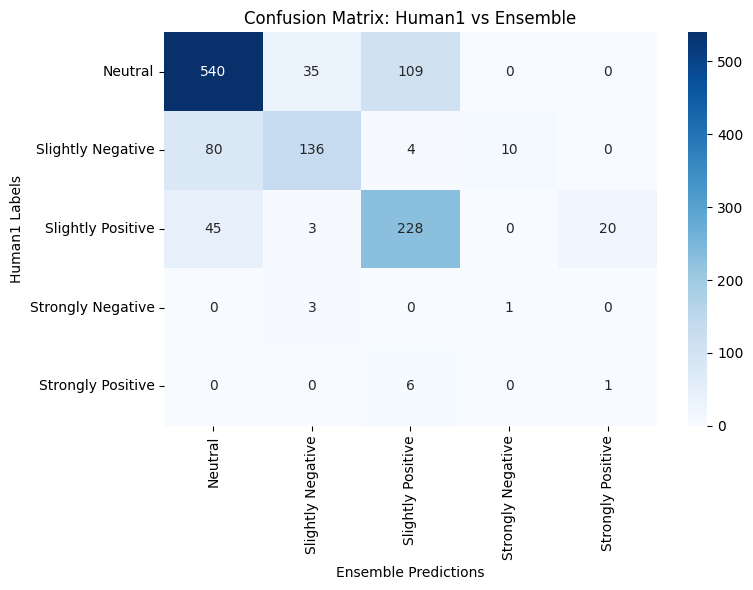

In [4]:
results_h1 = evaluate_annotator(df, 'human1_sentiment')
print("Individual Evaluation Results (Human1 vs Ensemble):")
print(f"Accuracy: {results_h1['accuracy']:.4f}")
print(f"Precision: {results_h1['precision']:.4f}")
print(f"Recall: {results_h1['recall']:.4f}")
print(f"F1 Score: {results_h1['f1']:.4f}")
print(f"Total samples: {results_h1['n']}")
print("\nClassification Report (Human1):\n" + results_h1['report'])

# Visualize confusion matrix for Human1
plt.figure(figsize=(8, 6))
sns.heatmap(results_h1['confusion_matrix'], annot=True, fmt='d', 
            xticklabels=results_h1['labels'], yticklabels=results_h1['labels'], cmap='Blues')
plt.xlabel('Ensemble Predictions')
plt.ylabel('Human1 Labels')
plt.title('Confusion Matrix: Human1 vs Ensemble')
plt.tight_layout()
plt.show()

### Human 2


Individual Evaluation Results (Human2 vs Ensemble):
Accuracy: 0.6404
Precision: 0.6588
Recall: 0.6404
F1 Score: 0.6436
Total samples: 2439

Classification Report (Human2):
                   precision    recall  f1-score   support

          Neutral       0.73      0.62      0.67      1264
Slightly Negative       0.65      0.56      0.60       393
Slightly Positive       0.57      0.73      0.64       737
Strongly Negative       0.24      0.29      0.26        17
Strongly Positive       0.23      0.50      0.32        28

         accuracy                           0.64      2439
        macro avg       0.48      0.54      0.50      2439
     weighted avg       0.66      0.64      0.64      2439



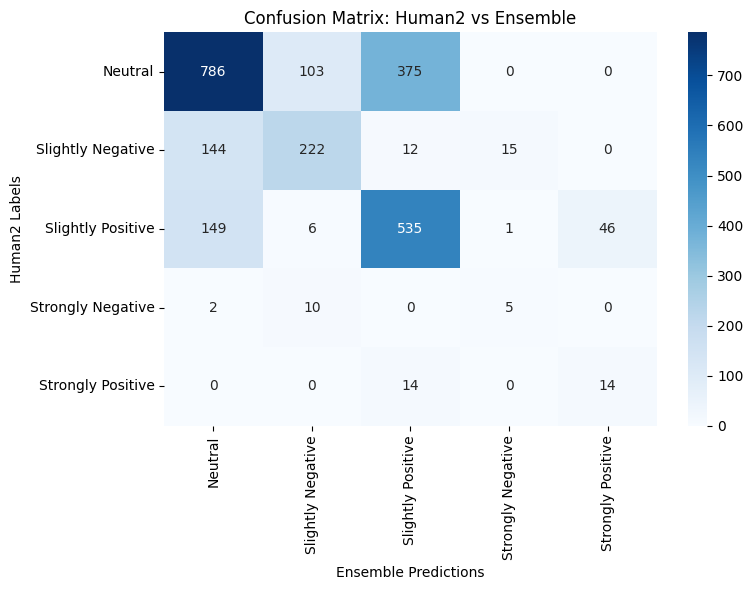

In [5]:
results_h2 = evaluate_annotator(df, 'human2_sentiment')
print("\nIndividual Evaluation Results (Human2 vs Ensemble):")
print(f"Accuracy: {results_h2['accuracy']:.4f}")
print(f"Precision: {results_h2['precision']:.4f}")
print(f"Recall: {results_h2['recall']:.4f}")
print(f"F1 Score: {results_h2['f1']:.4f}")
print(f"Total samples: {results_h2['n']}")
print("\nClassification Report (Human2):\n" + results_h2['report'])

# Visualize confusion matrix for Human2
plt.figure(figsize=(8, 6))
sns.heatmap(results_h2['confusion_matrix'], annot=True, fmt='d', 
            xticklabels=results_h2['labels'], yticklabels=results_h2['labels'], cmap='Blues')
plt.xlabel('Ensemble Predictions')
plt.ylabel('Human2 Labels')
plt.title('Confusion Matrix: Human2 vs Ensemble')
plt.tight_layout()
plt.show()

### Overall

In [ ]:
n_total = results_h1['n'] + results_h2['n']

overall_results = {
    'accuracy': (results_h1['accuracy'] * results_h1['n'] + 
                    results_h2['accuracy'] * results_h2['n']) / n_total,
    'precision': (results_h1['precision'] * results_h1['n'] + 
                    results_h2['precision'] * results_h2['n']) / n_total,
    'recall': (results_h1['recall'] * results_h1['n'] + 
                results_h2['recall'] * results_h2['n']) / n_total,
    'f1': (results_h1['f1'] * results_h1['n'] + 
            results_h2['f1'] * results_h2['n']) / n_total,
    'total_samples': n_total
}

print("\nOverall Evaluation Results (Weighted Average):")
print(f"Accuracy: {overall_results['accuracy']:.4f}")
print(f"Precision: {overall_results['precision']:.4f}")
print(f"Recall: {overall_results['recall']:.4f}")
print(f"F1 Score: {overall_results['f1']:.4f}")
print(f"Total samples: {overall_results['total_samples']}")

# Optional: Calculate metrics by pooling all labels
all_human_labels = results_h1['human_labels'] + results_h2['human_labels']
all_ens_labels = results_h1['ens_labels'] + results_h2['ens_labels']

pooled_accuracy = accuracy_score(all_human_labels, all_ens_labels)
pooled_precision = precision_score(all_human_labels, all_ens_labels, average='weighted', zero_division=0)
pooled_recall = recall_score(all_human_labels, all_ens_labels, average='weighted', zero_division=0)
pooled_f1 = f1_score(all_human_labels, all_ens_labels, average='weighted', zero_division=0)

print("\nOverall Evaluation Results (Pooled Labels):")
print(f"Accuracy: {pooled_accuracy:.4f}")
print(f"Precision: {pooled_precision:.4f}")
print(f"Recall: {pooled_recall:.4f}")
print(f"F1 Score: {pooled_f1:.4f}")

# Create a combined confusion matrix
all_labels = sorted(list(set(all_human_labels) | set(all_ens_labels)))
cm_combined = confusion_matrix(all_human_labels, all_ens_labels, labels=all_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_combined, annot=True, fmt='d', 
            xticklabels=all_labels, yticklabels=all_labels, cmap='Blues')
plt.xlabel('Ensemble Predictions')
plt.ylabel('Human Labels (Combined)')
plt.title('Confusion Matrix: Combined Human vs Ensemble')
plt.tight_layout()
plt.show()


## Random Test

In [ ]:
df_unlabeled = df[pd.isna(df['human1_sentiment']) & pd.isna(df['human2_sentiment'])]

# 1. Randomly assign sentiment labels
sentiment_classes = ["strongly negative", "slightly negative", "neutral", 
                     "slightly positive", "strongly positive"]
random_labels = np.random.choice(sentiment_classes, size=len(df_unlabeled))

# 2. Track error on randomly labeled data
random_accuracy = accuracy_score(random_labels, 
                                df_unlabeled["primary_sentiment"].tolist())

# 3. If random_accuracy is close to 0.2 (1/5 for 5 classes), model is not fitting to noise
print(f"Random Accuracy: {random_accuracy:.3f}")
print(f"Expected Random Accuracy: {1/len(sentiment_classes):.3f}")